In [3]:

import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import os 
import sys 

current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..','..','..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
    
from pipeline.plotting.TS_analysis import plot_TS
from jupyter_ipynb.NetMob_training_analysis.plotting import plot_boxplot_on_metric
from experiences.convert_df_to_latex import dataframe_to_latex,parse_index_exp1_2,parse_index_exp4



folder_path = 'save/K_fold_validation/training_wo_HP_tuning'

In [4]:
def format_results_to_dataframe(results_string):
    """
    Cette fonction transforme une chaîne de caractères de résultats en un DataFrame pandas,
    en extrayant la configuration, le RMSE, le MAE et le MASE pour chaque ligne.
    """
    
    data = []
    
    for line in results_string.strip().split('\n'):
        if not line.strip():
            continue

        parts = line.split(':')
        name = parts[0].strip()
        metrics_str = parts[1].strip()

        # Extraire la configuration
        config_match = re.search(r'STAEformer_bike_out_weather_calendar_(.*?)__e200', name)
        if config_match:
            config = config_match.group(1).strip('_')
            if not config:
                config = 'bike_out'
        else:
            config = 'baseline'

        # Extraire les métriques
        rmse_match = re.search(r'RMSE = ([\d.]+)', metrics_str)
        mae_match = re.search(r'MAE = ([\d.]+)', metrics_str)
        mase_match = re.search(r'MASE = ([\d.]+)', metrics_str)
        
        rmse = float(rmse_match.group(1)) if rmse_match else None
        mae = float(mae_match.group(1)) if mae_match else None
        mase = float(mase_match.group(1)) if mase_match else None
        
        data.append({
            'config': config,
            'RMSE': rmse,
            'MAE': mae,
            'MASE': mase
        })
        
    df = pd.DataFrame(data)
    return df

# from experiences.contextual_data_integration.A_unique.exp2_results import results
from experiences.contextual_data_integration.A_unique.exp2_rainy_results import results

df_init = format_results_to_dataframe(results) 

df = df_init.groupby('config').agg(['mean','std'])
baseline_index  = 'baseline'
df = df.sort_values(by=[('RMSE','mean')])
for c in df.columns:
    if 'mean' == c[1]:
        x = df[c].iloc[0]
        df[c] = df[c].apply(lambda x: f"{round(x,3)} ({round(100*(-1+x/df.loc[baseline_index,c]),2)}\%)")
df.index = [f"{c}__e200" for c in df.index]
df.columns = pd.MultiIndex.from_tuples([(x[0].lower() + '_h4',x[1]) for x in df.columns])
display(df)
caption = {r"Prediction of Bike-out (15min agg) at horizon [+45,+60min] with STAEformer using contextual data 'Weather' according to different Integration Strategies. Metrics are averaged over 5 runs."}
print("%%% LaTeX code for Experiment 1 Table %%%\n")
latex_table_1 = dataframe_to_latex(df, caption, "exp2_rainy", parse_index_exp1_2)
print(latex_table_1)

rmse_h4                     mae_h4  \
                                             mean       std             mean   
early_fusion_repeat_t_proj__e200  4.858 (-5.81\%)  0.108154  2.968 (-4.21\%)   
late_fusion_repeat_t_proj__e200   4.921 (-4.59\%)  0.051578  3.012 (-2.78\%)   
early_fusion_s_proj_t_proj__e200   4.96 (-3.85\%)  0.079074   3.02 (-2.52\%)   
late_fusion_s_proj_t_proj__e200    4.96 (-3.83\%)  0.063090  3.019 (-2.56\%)   
baseline__e200                      5.158 (0.0\%)  0.064348    3.098 (0.0\%)   

                                                    mase_h4            
                                       std             mean       std  
early_fusion_repeat_t_proj__e200  0.054614  0.624 (-4.21\%)  0.011498  
late_fusion_repeat_t_proj__e200   0.030963  0.633 (-2.76\%)  0.006380  
early_fusion_s_proj_t_proj__e200  0.036688  0.635 (-2.52\%)  0.007662  
late_fusion_s_proj_t_proj__e200   0.023059  0.635 (-2.55\%)  0.004930  
baseline__e200                    0.035801    0.651 (0.0\%)  0.007328

%%% LaTeX code for Experiment 1 Table %%%

\begin{table}[!htb]
    \centering
    \caption{{"Prediction of Bike-out (15min agg) at horizon [+45,+60min] with STAEformer using contextual data 'Weather' according to different Integration Strategies. Metrics are averaged over 5 runs."}}
    \label{tab:exp2_rainy}
    \resizebox{\textwidth}{!}{
    \begin{tabular}{{llcccccc}}
        \toprule
        Contextual Data & Integration Strategy & \multicolumn{2}{c}{ MAE (h4) } & \multicolumn{2}{c}{ MASE (h4) } & \multicolumn{2}{c}{ RMSE (h4) } \\
        \cmidrule(lr){1-2} \cmidrule(lr){3-4} \cmidrule(lr){5-6} \cmidrule(lr){7-8}
         &  & Mean & Std & Mean & Std & Mean & Std \\
        \midrule
        \midrule
        No & Baseline (No Context) & 2.968 (-4.21\%) & 0.0546 & 0.624 (-4.21\%) & 0.0115 & 4.858 (-5.81\%) & 0.1082 \\
        \midrule
        No & Baseline (No Context) & 3.012 (-2.78\%) & 0.0310 & 0.633 (-2.76\%) & 0.0064 & 4.921 (-4.59\%) & 0.0516 \\
        \midrule
        No & B

In [11]:
# from experiences.contextual_data_integration.A_unique.exp2_rainy_results import results 
from experiences.contextual_data_integration.A_unique.exp2_results import results 
df_init = format_results_to_dataframe(results) 

def replace_diminutif(x):
    x = x.replace('L_','Late Fusion ')
    x = x.replace('E_','Early Fusion ')
    x = x.replace('BB','Backbone ')
    return x
def f_replace(x):
    x = x.replace('early_fusion','E')
    x = x.replace('late_fusion','L')
    x = x.replace('s_proj_t_proj','S-Proj T-proj')
    x = x.replace('repeat_t_proj','Repeat T-proj')
    x = x.replace('feature_extractor','SprojCrossAttn')
    x = x.replace('baseline','Baseline')
    return x

df_init['config'] = df_init['config'].apply(f_replace)
df_init['id'] = df_init['config']
df_init['config'] = df_init['config'].apply(replace_diminutif)
# plot_boxplot_on_metric(df_init, metric_i='MAE', xaxis_label="Config", legend_group='config', width=800, height=600, 
#                             save_path=None)
horizon = '4'

# title = f'RMSE Distribution on RAINY set per Config and Fusion Strategy of Bike-Out Prediction at Horizon [{15*(int(horizon)-1)} - {15*(int(horizon))}]min'
title = f'RMSE Distribution per Config and Fusion Strategy of Bike-Out Prediction at Horizon [{15*(int(horizon)-1)} - {15*(int(horizon))}]min'
plot_boxplot_on_metric(df_init, metric_i='RMSE', xaxis_label="Config", legend_group='config', width=800, height=600, 
                            save_path=None,
                            title=title
                            )

# title = f'MASE Distribution on RAINY set per Config and Fusion Strategy of Bike-Out Prediction at Horizon [{15*(int(horizon)-1)} - {15*(int(horizon))}]min'
title = f'MASE Distribution per Config and Fusion Strategy of Bike-Out Prediction at Horizon [{15*(int(horizon)-1)} - {15*(int(horizon))}]min'
plot_boxplot_on_metric(df_init, metric_i='MASE', xaxis_label="Config", legend_group='config', width=800, height=400, 
                            save_path=None,
                            title=title
                            )


# STAEformer_bike_out_calendar__e200_h4_:   All Steps RMSE = 5.15810, MAE = 3.09788, MASE = 0.65106, MAPE = 61.84408
# STAEformer_bike_out_weather_calendar_late_fusion_feature_extractor__e200_h4_:   All Steps RMSE = 4.95610, MAE = 3.01653, MASE = 0.63396, MAPE = 60.49832
# STAEformer_bike_out_weather_calendar_late_fusion_s_proj_t_proj__e200_h4_:   All Steps RMSE = 4.96058, MAE = 3.01893, MASE = 0.63447, MAPE = 59.90341
# STAEformer_bike_out_weather_calendar_late_fusion_repeat_t_proj__e200_h4_:   All Steps RMSE = 4.92135, MAE = 3.01220, MASE = 0.63305, MAPE = 60.93101
# STAEformer_bike_out_weather_calendar_early_fusion_repeat_t_proj__e200_h4_:   All Steps RMSE = 4.85858, MAE = 2.96794, MASE = 0.62375, MAPE = 57.65172
# STAEformer_bike_out_weather_calendar_early_fusion_s_proj_t_proj__e200_h4_:   All Steps RMSE = 4.96001, MAE = 3.02018, MASE = 0.63473, MAPE = 58.95483
# STAEformer_bike_out_weather_calendar_early_fusion_feature_extractor__e200_h4_:   All Steps RMSE = 4.82777, MAE = 2.95462, MASE = 0.62095, MAPE = 57.24392

Loading BokehJS ...

Loading BokehJS ...

# Desagregated Plot 

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No module xgboost
Training and Hyper-parameter tuning with Ray is not possible
Training and Hyper-parameter tuning with Ray is not possible

Exp2
Trial id Ref:  STAEformer_bike_out_calendar__e200_h4_bis
Trial id to test: 
STAEformer_bike_out_weather_calendar_late_fusion_feature_extractor__e200_h4_bis
STAEformer_bike_out_weather_calendar_late_fusion_s_proj_t_proj__e200_h4_bis
STAEformer_bike_out_weather_calendar_late_fusion_repeat_t_proj__e200_h4_bis
STAEformer_bike_out_weather_calendar_early_fusion_repeat_t_proj__e200_h4_bis
STAEformer_bike_out_weather_calendar_early_fusion_s_proj_t_proj__e200_h4_bis
STAEformer_bike_out_weather_calendar_early_fusion_feature_extractor__e200_h4_bis
Trial ID 1:  _STAEformer_bike_out_calendar__e200_h4_bis1_f5
Trial ID 2:  _STAEformer_bike_out_weather_calendar_late_fusion_feature_extractor__e200_h4_bis1_f5
model_save_path for trial id1:  /home/rrochas/prediction-validation/save/K_fold_validation/training_wo_HP_tuning/Exp2/bike_out_STAEformer/best_models/STA

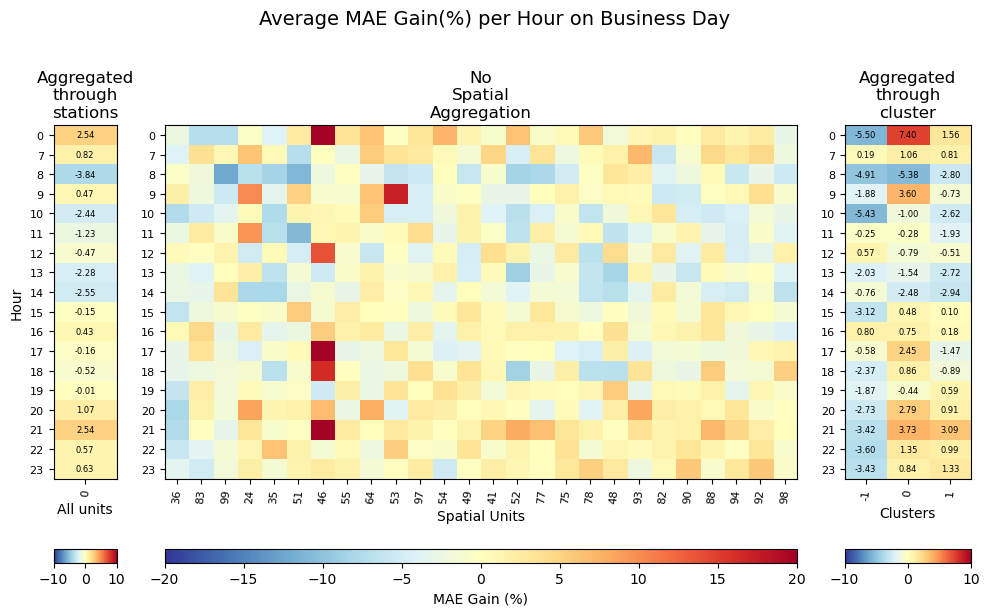


Comparison on between models across all time-slots followed by comparison on Rainy Events Only
Number of rainy time-slots in the train set:
 Between 0 and 0.05 mm: 744, i.e 4.73 % of the train set and 32.99 % of the rainy time-slots
 Between 0.05 and 0.5 mm: 919, i.e 5.84 % of the train set and 40.75 % of the rainy time-slots
 Between 0.5 and 1 mm: 289, i.e 1.84 % of the train set and 12.82 % of the rainy time-slots
 Between 1 and inf mm: 303, i.e 1.93 % of the train set and 13.44 % of the rainy time-slots
Number of rainy time-slots in the train set: 2255, i.e 14.34 % of the train set
Number of rainy time-slots in the test set: 1228, i.e 23.43 % of the test set

Model1 correspond to :  STAEformer_bike_out_calendar__e200_h4_bis
Model2 correspond to :  STAEformer_bike_out_weather_calendar_late_fusion_feature_extractor__e200_h4_bis


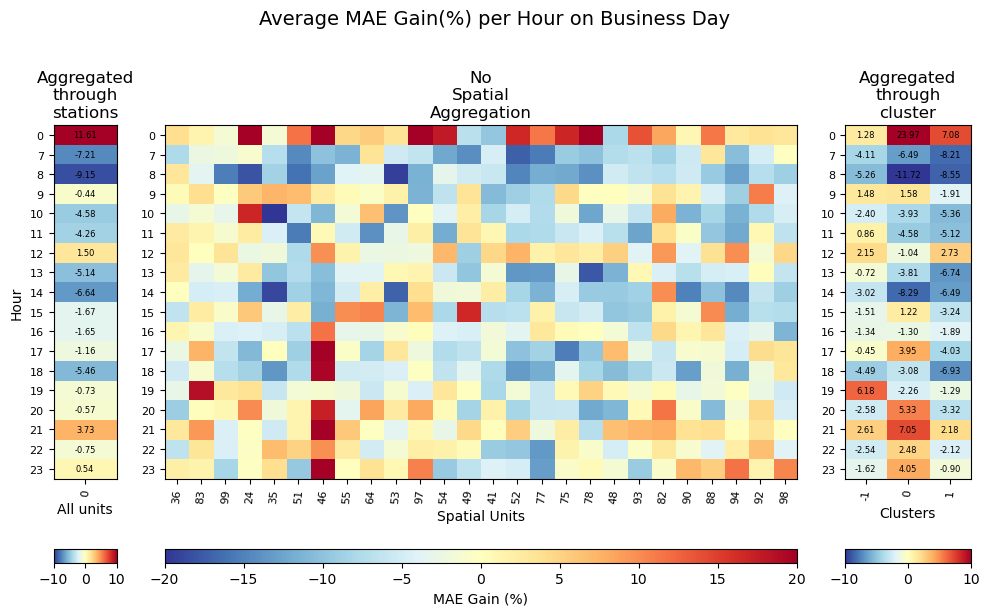


STAEformer_bike_out_calendar__e200_h4_:   All Steps RMSE = 5.15810, MAE = 3.09788, MASE = 0.65106, MAPE = 61.84408
STAEformer_bike_out_weather_calendar_late_fusion_feature_extractor__e200_h4_:   All Steps RMSE = 4.95610, MAE = 3.01653, MASE = 0.63396, MAPE = 60.49832

Trial ID 1:  _STAEformer_bike_out_calendar__e200_h4_bis1_f5
Trial ID 2:  _STAEformer_bike_out_weather_calendar_late_fusion_s_proj_t_proj__e200_h4_bis1_f5
model_save_path for trial id1:  /home/rrochas/prediction-validation/save/K_fold_validation/training_wo_HP_tuning/Exp2/bike_out_STAEformer/best_models/STAEformer_bike_out_calendar__e200_h4_bis1_f5.pkl
----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 35040 elts between 2019-01-01 00:00:00 and 2019-12-31 23:45:00
Invalid dates within this fold: 0

>>>Tackle Target dataset: bike_out
Loading from /home/rrochas/../../data/rrochas/prediction_validation/agg_data/velov/velov_emitted_by_station15min.csv...
df pivoted:  (7

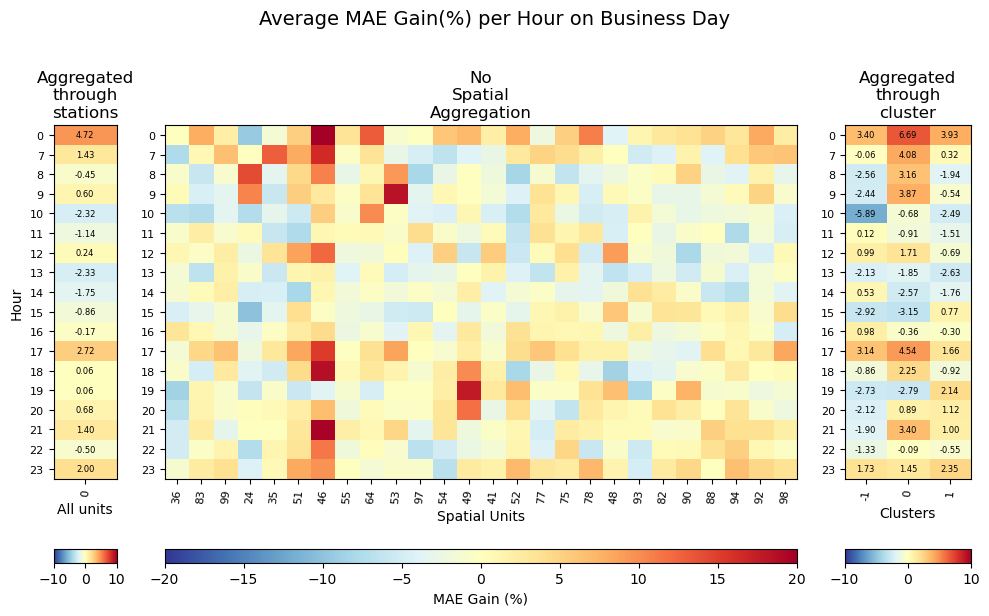


Comparison on between models across all time-slots followed by comparison on Rainy Events Only
Number of rainy time-slots in the train set:
 Between 0 and 0.05 mm: 744, i.e 4.73 % of the train set and 32.99 % of the rainy time-slots
 Between 0.05 and 0.5 mm: 919, i.e 5.84 % of the train set and 40.75 % of the rainy time-slots
 Between 0.5 and 1 mm: 289, i.e 1.84 % of the train set and 12.82 % of the rainy time-slots
 Between 1 and inf mm: 303, i.e 1.93 % of the train set and 13.44 % of the rainy time-slots
Number of rainy time-slots in the train set: 2255, i.e 14.34 % of the train set
Number of rainy time-slots in the test set: 1228, i.e 23.43 % of the test set

Model1 correspond to :  STAEformer_bike_out_calendar__e200_h4_bis
Model2 correspond to :  STAEformer_bike_out_weather_calendar_late_fusion_s_proj_t_proj__e200_h4_bis


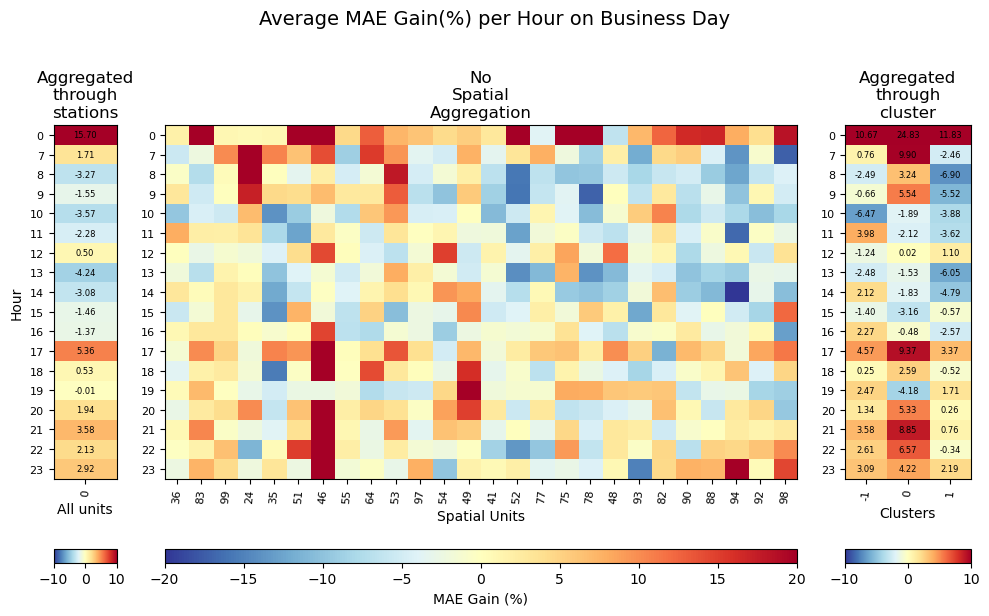


STAEformer_bike_out_calendar__e200_h4_:   All Steps RMSE = 5.15810, MAE = 3.09788, MASE = 0.65106, MAPE = 61.84408
STAEformer_bike_out_weather_calendar_late_fusion_feature_extractor__e200_h4_:   All Steps RMSE = 4.95610, MAE = 3.01653, MASE = 0.63396, MAPE = 60.49832
STAEformer_bike_out_weather_calendar_late_fusion_s_proj_t_proj__e200_h4_:   All Steps RMSE = 4.96058, MAE = 3.01893, MASE = 0.63447, MAPE = 59.90341

Trial ID 1:  _STAEformer_bike_out_calendar__e200_h4_bis1_f5
Trial ID 2:  _STAEformer_bike_out_weather_calendar_late_fusion_repeat_t_proj__e200_h4_bis1_f5
model_save_path for trial id1:  /home/rrochas/prediction-validation/save/K_fold_validation/training_wo_HP_tuning/Exp2/bike_out_STAEformer/best_models/STAEformer_bike_out_calendar__e200_h4_bis1_f5.pkl
----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 35040 elts between 2019-01-01 00:00:00 and 2019-12-31 23:45:00
Invalid dates within this fold: 0

>>>Tackle Target data

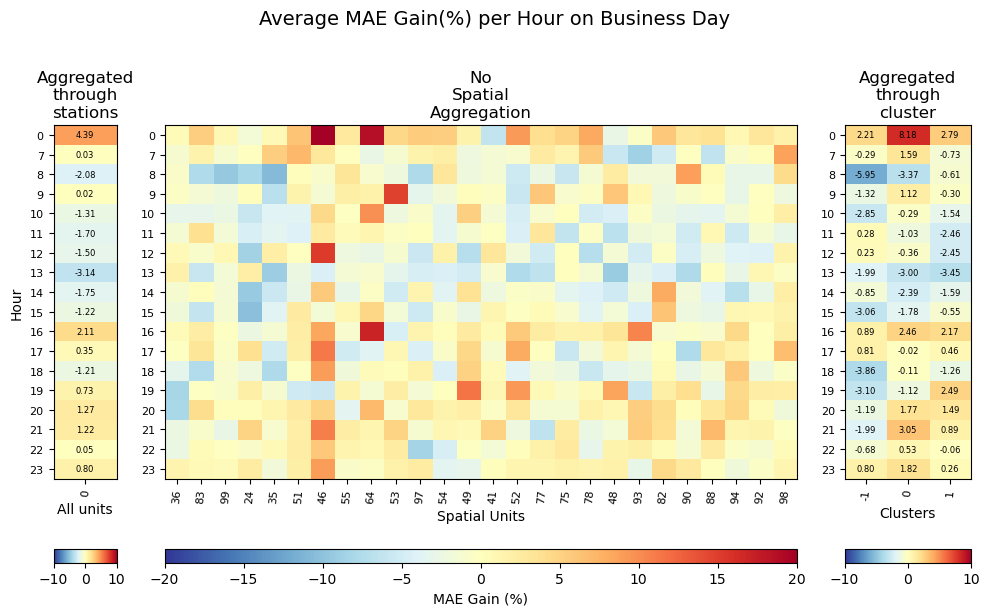


Comparison on between models across all time-slots followed by comparison on Rainy Events Only
Number of rainy time-slots in the train set:
 Between 0 and 0.05 mm: 744, i.e 4.73 % of the train set and 32.99 % of the rainy time-slots
 Between 0.05 and 0.5 mm: 919, i.e 5.84 % of the train set and 40.75 % of the rainy time-slots
 Between 0.5 and 1 mm: 289, i.e 1.84 % of the train set and 12.82 % of the rainy time-slots
 Between 1 and inf mm: 303, i.e 1.93 % of the train set and 13.44 % of the rainy time-slots
Number of rainy time-slots in the train set: 2255, i.e 14.34 % of the train set
Number of rainy time-slots in the test set: 1228, i.e 23.43 % of the test set

Model1 correspond to :  STAEformer_bike_out_calendar__e200_h4_bis
Model2 correspond to :  STAEformer_bike_out_weather_calendar_late_fusion_repeat_t_proj__e200_h4_bis


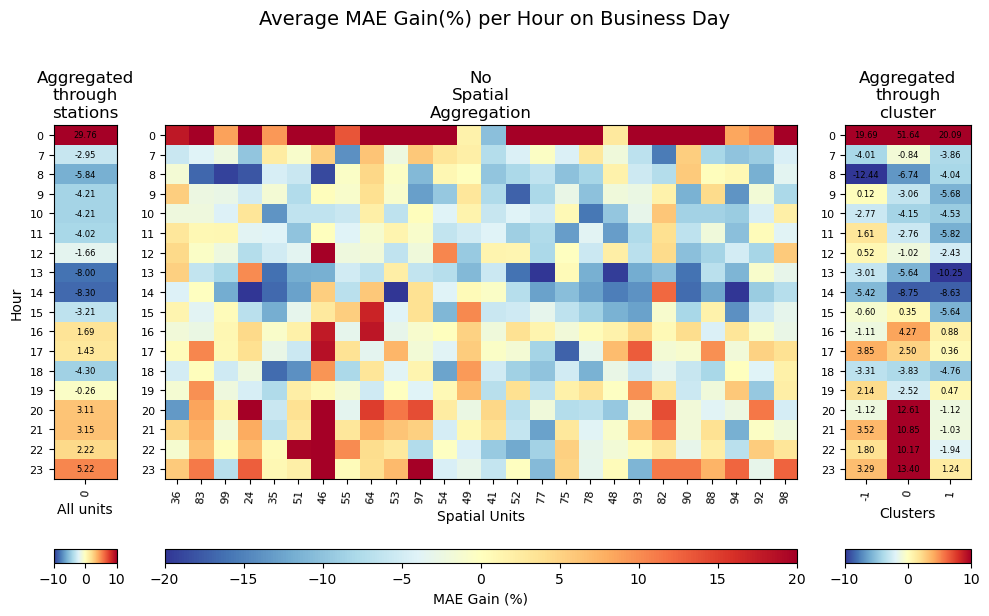


STAEformer_bike_out_calendar__e200_h4_:   All Steps RMSE = 5.15810, MAE = 3.09788, MASE = 0.65106, MAPE = 61.84408
STAEformer_bike_out_weather_calendar_late_fusion_feature_extractor__e200_h4_:   All Steps RMSE = 4.95610, MAE = 3.01653, MASE = 0.63396, MAPE = 60.49832
STAEformer_bike_out_weather_calendar_late_fusion_s_proj_t_proj__e200_h4_:   All Steps RMSE = 4.96058, MAE = 3.01893, MASE = 0.63447, MAPE = 59.90341
STAEformer_bike_out_weather_calendar_late_fusion_repeat_t_proj__e200_h4_:   All Steps RMSE = 4.92135, MAE = 3.01220, MASE = 0.63305, MAPE = 60.93101

Trial ID 1:  _STAEformer_bike_out_calendar__e200_h4_bis1_f5
Trial ID 2:  _STAEformer_bike_out_weather_calendar_early_fusion_repeat_t_proj__e200_h4_bis1_f5
model_save_path for trial id1:  /home/rrochas/prediction-validation/save/K_fold_validation/training_wo_HP_tuning/Exp2/bike_out_STAEformer/best_models/STAEformer_bike_out_calendar__e200_h4_bis1_f5.pkl
----------------------------------------
Loading the Complete Dataset for K-f

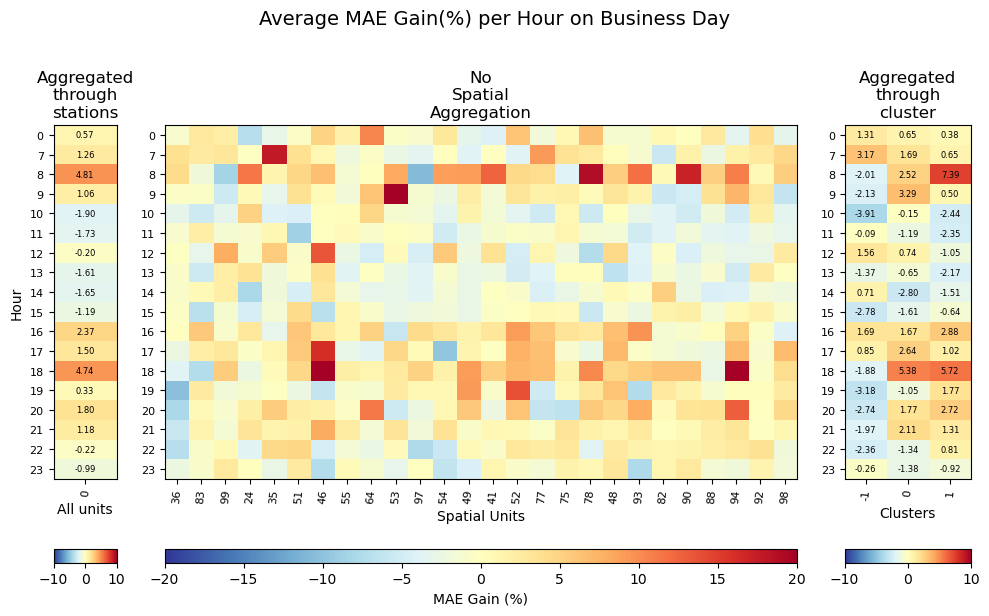


Comparison on between models across all time-slots followed by comparison on Rainy Events Only
Number of rainy time-slots in the train set:
 Between 0 and 0.05 mm: 744, i.e 4.73 % of the train set and 32.99 % of the rainy time-slots
 Between 0.05 and 0.5 mm: 919, i.e 5.84 % of the train set and 40.75 % of the rainy time-slots
 Between 0.5 and 1 mm: 289, i.e 1.84 % of the train set and 12.82 % of the rainy time-slots
 Between 1 and inf mm: 303, i.e 1.93 % of the train set and 13.44 % of the rainy time-slots
Number of rainy time-slots in the train set: 2255, i.e 14.34 % of the train set
Number of rainy time-slots in the test set: 1228, i.e 23.43 % of the test set

Model1 correspond to :  STAEformer_bike_out_calendar__e200_h4_bis
Model2 correspond to :  STAEformer_bike_out_weather_calendar_early_fusion_repeat_t_proj__e200_h4_bis


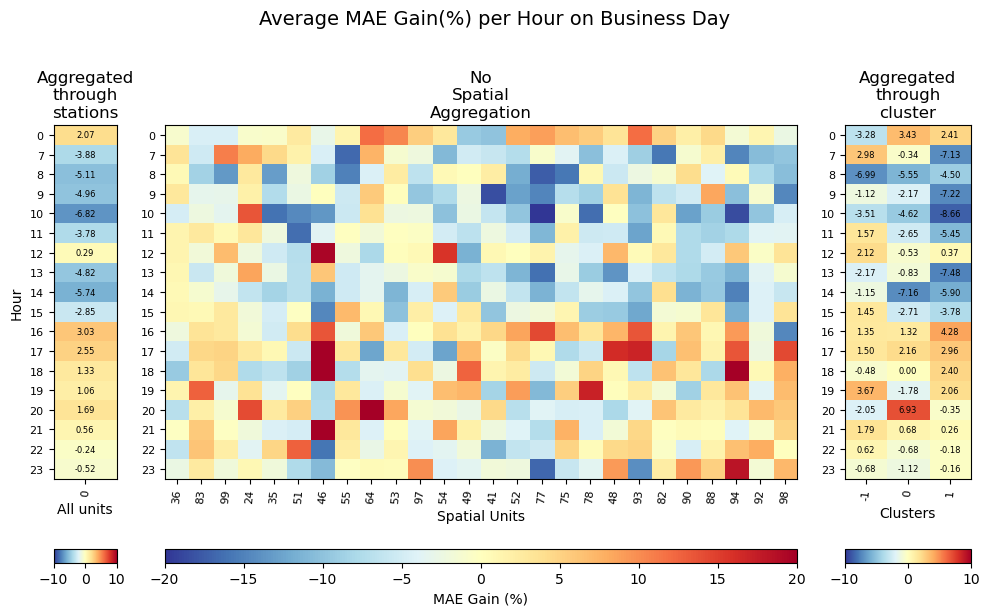


STAEformer_bike_out_calendar__e200_h4_:   All Steps RMSE = 5.15810, MAE = 3.09788, MASE = 0.65106, MAPE = 61.84408
STAEformer_bike_out_weather_calendar_late_fusion_feature_extractor__e200_h4_:   All Steps RMSE = 4.95610, MAE = 3.01653, MASE = 0.63396, MAPE = 60.49832
STAEformer_bike_out_weather_calendar_late_fusion_s_proj_t_proj__e200_h4_:   All Steps RMSE = 4.96058, MAE = 3.01893, MASE = 0.63447, MAPE = 59.90341
STAEformer_bike_out_weather_calendar_late_fusion_repeat_t_proj__e200_h4_:   All Steps RMSE = 4.92135, MAE = 3.01220, MASE = 0.63305, MAPE = 60.93101
STAEformer_bike_out_weather_calendar_early_fusion_repeat_t_proj__e200_h4_:   All Steps RMSE = 4.85858, MAE = 2.96794, MASE = 0.62375, MAPE = 57.65172

Trial ID 1:  _STAEformer_bike_out_calendar__e200_h4_bis1_f5
Trial ID 2:  _STAEformer_bike_out_weather_calendar_early_fusion_s_proj_t_proj__e200_h4_bis1_f5
model_save_path for trial id1:  /home/rrochas/prediction-validation/save/K_fold_validation/training_wo_HP_tuning/Exp2/bike_out_

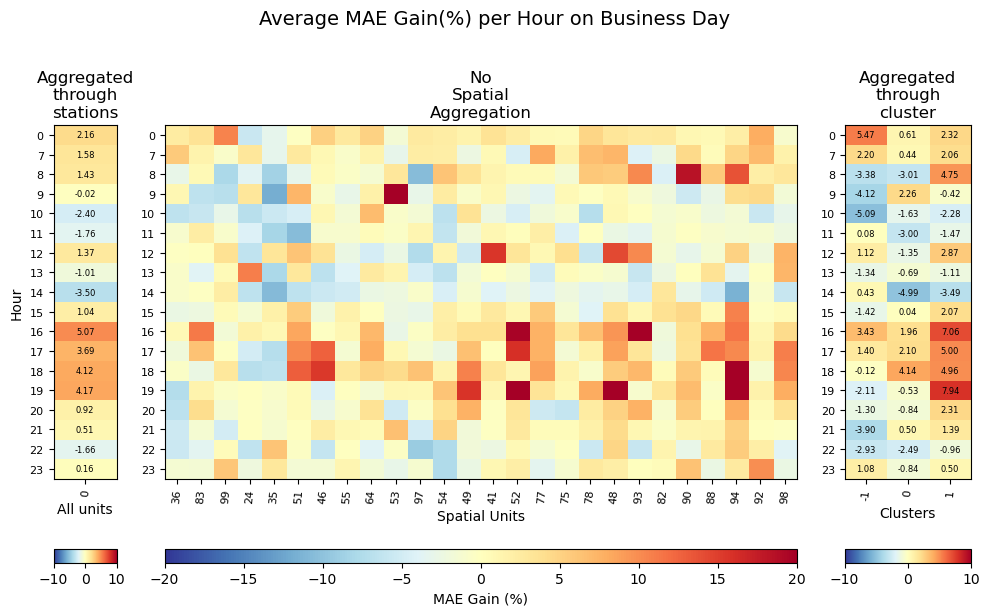


Comparison on between models across all time-slots followed by comparison on Rainy Events Only
Number of rainy time-slots in the train set:
 Between 0 and 0.05 mm: 744, i.e 4.73 % of the train set and 32.99 % of the rainy time-slots
 Between 0.05 and 0.5 mm: 919, i.e 5.84 % of the train set and 40.75 % of the rainy time-slots
 Between 0.5 and 1 mm: 289, i.e 1.84 % of the train set and 12.82 % of the rainy time-slots
 Between 1 and inf mm: 303, i.e 1.93 % of the train set and 13.44 % of the rainy time-slots
Number of rainy time-slots in the train set: 2255, i.e 14.34 % of the train set
Number of rainy time-slots in the test set: 1228, i.e 23.43 % of the test set

Model1 correspond to :  STAEformer_bike_out_calendar__e200_h4_bis
Model2 correspond to :  STAEformer_bike_out_weather_calendar_early_fusion_s_proj_t_proj__e200_h4_bis


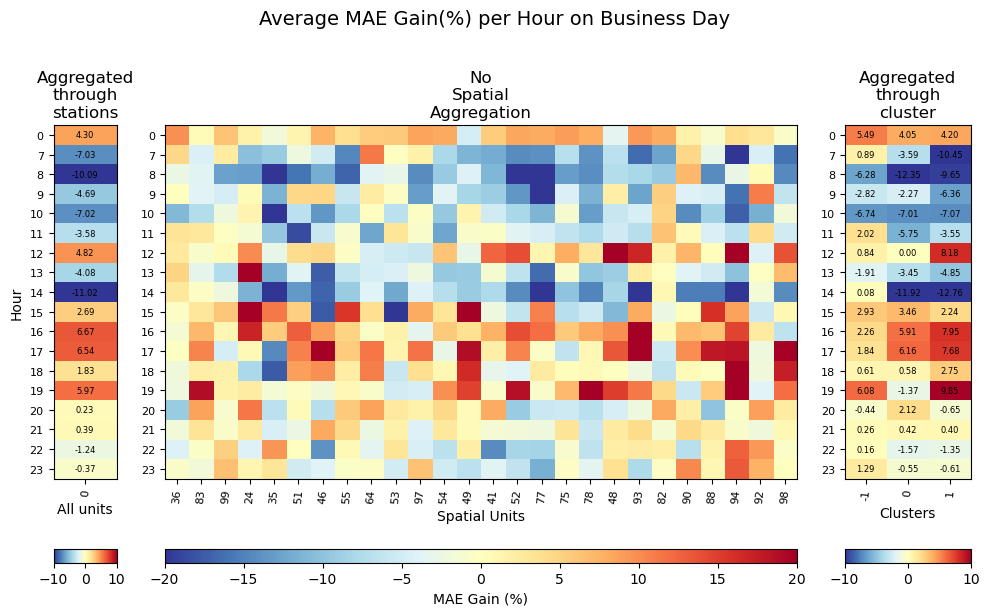


STAEformer_bike_out_calendar__e200_h4_:   All Steps RMSE = 5.15810, MAE = 3.09788, MASE = 0.65106, MAPE = 61.84408
STAEformer_bike_out_weather_calendar_late_fusion_feature_extractor__e200_h4_:   All Steps RMSE = 4.95610, MAE = 3.01653, MASE = 0.63396, MAPE = 60.49832
STAEformer_bike_out_weather_calendar_late_fusion_s_proj_t_proj__e200_h4_:   All Steps RMSE = 4.96058, MAE = 3.01893, MASE = 0.63447, MAPE = 59.90341
STAEformer_bike_out_weather_calendar_late_fusion_repeat_t_proj__e200_h4_:   All Steps RMSE = 4.92135, MAE = 3.01220, MASE = 0.63305, MAPE = 60.93101
STAEformer_bike_out_weather_calendar_early_fusion_repeat_t_proj__e200_h4_:   All Steps RMSE = 4.85858, MAE = 2.96794, MASE = 0.62375, MAPE = 57.65172
STAEformer_bike_out_weather_calendar_early_fusion_s_proj_t_proj__e200_h4_:   All Steps RMSE = 4.96001, MAE = 3.02018, MASE = 0.63473, MAPE = 58.95483

Trial ID 1:  _STAEformer_bike_out_calendar__e200_h4_bis1_f5
Trial ID 2:  _STAEformer_bike_out_weather_calendar_early_fusion_feature_

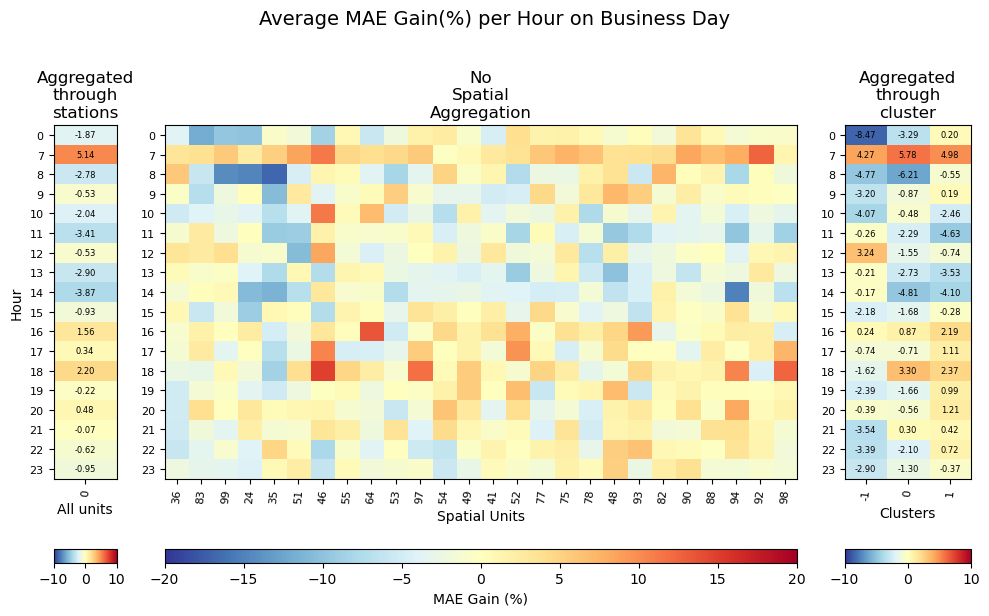


Comparison on between models across all time-slots followed by comparison on Rainy Events Only
Number of rainy time-slots in the train set:
 Between 0 and 0.05 mm: 744, i.e 4.73 % of the train set and 32.99 % of the rainy time-slots
 Between 0.05 and 0.5 mm: 919, i.e 5.84 % of the train set and 40.75 % of the rainy time-slots
 Between 0.5 and 1 mm: 289, i.e 1.84 % of the train set and 12.82 % of the rainy time-slots
 Between 1 and inf mm: 303, i.e 1.93 % of the train set and 13.44 % of the rainy time-slots
Number of rainy time-slots in the train set: 2255, i.e 14.34 % of the train set
Number of rainy time-slots in the test set: 1228, i.e 23.43 % of the test set

Model1 correspond to :  STAEformer_bike_out_calendar__e200_h4_bis
Model2 correspond to :  STAEformer_bike_out_weather_calendar_early_fusion_feature_extractor__e200_h4_bis


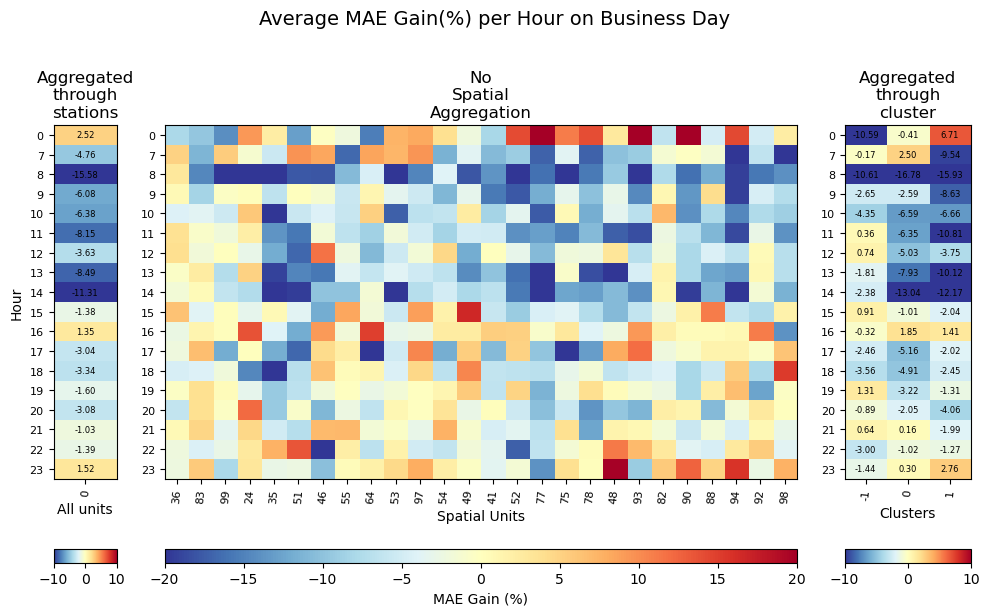


STAEformer_bike_out_calendar__e200_h4_:   All Steps RMSE = 5.15810, MAE = 3.09788, MASE = 0.65106, MAPE = 61.84408
STAEformer_bike_out_weather_calendar_late_fusion_feature_extractor__e200_h4_:   All Steps RMSE = 4.95610, MAE = 3.01653, MASE = 0.63396, MAPE = 60.49832
STAEformer_bike_out_weather_calendar_late_fusion_s_proj_t_proj__e200_h4_:   All Steps RMSE = 4.96058, MAE = 3.01893, MASE = 0.63447, MAPE = 59.90341
STAEformer_bike_out_weather_calendar_late_fusion_repeat_t_proj__e200_h4_:   All Steps RMSE = 4.92135, MAE = 3.01220, MASE = 0.63305, MAPE = 60.93101
STAEformer_bike_out_weather_calendar_early_fusion_repeat_t_proj__e200_h4_:   All Steps RMSE = 4.85858, MAE = 2.96794, MASE = 0.62375, MAPE = 57.65172
STAEformer_bike_out_weather_calendar_early_fusion_s_proj_t_proj__e200_h4_:   All Steps RMSE = 4.96001, MAE = 3.02018, MASE = 0.63473, MAPE = 58.95483
STAEformer_bike_out_weather_calendar_early_fusion_feature_extractor__e200_h4_:   All Steps RMSE = 4.82777, MAE = 2.95462, MASE = 0.62

In [1]:
from experiences.common_results import dic_exp_to_names,dic_trials
from experiences.get_desagregated_plot import get_desagregated_gains

range_k = range(1,6) # range(1,6)
comparison_on_rainy_events =  True #False 
station_clustering = True 
horizons = [4] # [1,4]
init_folder_path = f"/home/rrochas/prediction-validation/save"

# ---- For producing only Bike-out on rainy plots: --- 
dic_exp_to_names = {'Exp2': dic_exp_to_names['Exp2']}

get_desagregated_gains(dic_exp_to_names,dic_trials,horizons,comparison_on_rainy_events,range_k,station_clustering,init_folder_path,save_bool = False)

# Get metrics on rainy events: 

In [ ]:
## Load trained model and return performance on rainy time-slots : 


import os 
import sys 

current_path = os.path.abspath(os.getcwd())
parent_dir = os.path.abspath(os.path.join(current_path, '..','..','..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from examples.accuracy_comparison import load_trainer_ds_from_2_trials,get_predict_real_and_inputs,get_model_args
from examples.accuracy_comparison import get_rainy_indices,plot_analysis_comparison_2_config,get_previous_and_prediction,get_gain_from_mod1
import torch 
from pipeline.utils.metrics import evaluate_metrics

def get_dict_metrics_on_rainy_events(full_predict1,full_predict2,Y_true,X,args_init1,args_init2,ds2):
    h_idx = 1
    metric_list = ['rmse','mse','mae','mase','mape']
    previous,_,_,_ = get_previous_and_prediction(full_predict1,full_predict2,Y_true,X,h_idx)
    assert args_init1.horizon_step == args_init1.step_ahead, "Horizon step must be equal to step_ahead here"

    print("\nComparison on between models across all time-slots followed by comparison on Rainy Events Only")
    _,train_rainy_indices,_,_ = get_rainy_indices(args = args_init2,ds = ds2,training_mode = 'train')
    print(f"Number of rainy time-slots in the train set: {len(train_rainy_indices)}, i.e {len(train_rainy_indices)/len(ds2.tensor_limits_keeper.df_verif_train)*100:.2f} % of the train set")
    # ---- Plot Accuracy comparison on rainy moments only ----
    mask,rainy_indices,df_weather,_ = get_rainy_indices(args = args_init2,ds = ds2,training_mode = 'test')
    print(f"Number of rainy time-slots in the test set: {len(rainy_indices)}, i.e {len(rainy_indices)/len(ds2.tensor_limits_keeper.df_verif_test)*100:.2f} % of the test set\n")

    dates = mask[mask].index
    masked_index = mask.reset_index(drop=True)
    masked_index = masked_index[masked_index].index


    # --- Get Prediction on rainy time-slots:
    rainy_predict1 = torch.index_select(full_predict1,0,torch.tensor(masked_index).long())
    rainy_predict2 = torch.index_select(full_predict2,0,torch.tensor(masked_index).long())
    rainy_Y_true = torch.index_select(Y_true,0,torch.tensor(masked_index).long())
    rainy_previous = torch.index_select(previous,0,torch.tensor(masked_index).long())

    dic_metric1 = evaluate_metrics(rainy_predict1,rainy_Y_true,metrics = metric_list, previous = rainy_previous,horizon_step = h_idx)
    dic_metric1 = dict(dic_metric1.copy())
    dic_metric2 = evaluate_metrics(rainy_predict2,rainy_Y_true,metrics = metric_list, previous = rainy_previous,horizon_step = h_idx)
    dic_metric2 = dict(dic_metric2.copy())
    return dic_metric1,dic_metric2



dic_contextual_data = {'bike_out': [['weather','calendar'],[]],  #,['weather','calendar']  # []
                    }

dic_fusion_strategie = {('bike_out',()): [''],
                        ('bike_out',('weather','calendar')):['early_fusion','late_fusion'],
                        }
             
dic_feature_extractor = {('bike_out',()): [''],
                        ('bike_out',('weather','calendar')):['repeat_t_proj','feature_extractor']
                        }


model_name = 'STAEformer'
epochs = 200
range_k = range(1,6)
training_mode = 'test'
modification = {'shuffle':False,
                'data_augmentation':False,
                'torch_compile': False,
                }
log = ''
Exp = 'Exp2'  # 'Exp2'

for horizon in [4]:
    for target in ['bike_out']:
        for contextual_data in dic_contextual_data[target]:
            reversed_metric = False
            fusion_strategies = dic_fusion_strategie[(target,tuple(contextual_data))]
            for fusion_strategie in fusion_strategies:
                feature_extractors = dic_feature_extractor[(target,tuple(contextual_data))]
                for feature_extractor in feature_extractors:
                    if not('weather' in contextual_data):
                        print('\n------------------------------------------------------\nContextual data:\n')
                        contextual_data1 = ['weather','calendar'] if target == 'bike_out' else ['subway_in','weather','calendar']
                        fusion_strategie1 = dic_fusion_strategie[(target,tuple(contextual_data1))][0]
                        feature_extractor1 = dic_feature_extractor[(target,tuple(contextual_data1))][0]

                        trial_id1 = f"{model_name}_{target}_calendar__e{epochs}_h{horizon}_bis"
                        trial_id2 = f"{model_name}_{target}_{'_'.join(contextual_data1)}_{fusion_strategie1}_{feature_extractor1}__e{epochs}_h{horizon}_bis"
                        reversed_metric = True 
                    else:
                        trial_id1 = f"{model_name}_{target}_calendar__e{epochs}_h{horizon}_bis"
                        trial_id2 = f"{model_name}_{target}_{'_'.join(contextual_data)}_{fusion_strategie}_{feature_extractor}__e{epochs}_h{horizon}_bis"

                    model_args,_,path_model_args,_ = get_model_args(save_folder_name = f'{Exp}/{target}_{model_name}')
                    ds1,ds2,args_init1,args_init2 = None, None, None, None
                    for k in range_k:
                        trial_id1_updated = f"{trial_id1}{k}_f5"
                        trial_id2_updated = f"{trial_id2}{k}_f5"

                        trainer1,trainer2,ds1,ds2,args_init1,args_init2 = load_trainer_ds_from_2_trials(trial_id1_updated,trial_id2_updated,modification = modification,
                                                                                                        model_args=model_args,
                                                                                                        path_model_args=path_model_args,
                                                                                                        ds1_init=ds1,ds2_init=ds2,
                                                                                                        args_init1=args_init1,args_init2=args_init2,
                                                                                                        )
                                                                                                        

                        full_predict1,full_predict2,Y_true,X = get_predict_real_and_inputs(trainer1,trainer2,ds1,ds2,training_mode=training_mode)

                        globals()[f"trainer1_bis{k}"] = trainer1
                        globals()[f"trainer2_bis{k}"] = trainer2
                        globals()[f"ds1_bis{k}"] = ds1
                        globals()[f"ds2_bis{k}"] = ds2
                        globals()[f"full_predict1_bis{k}"] = full_predict1
                        globals()[f"full_predict2_bis{k}"] = full_predict2

                        dic_metric1,dic_metric2 = get_dict_metrics_on_rainy_events(globals()[f"full_predict1_bis{k}"],globals()[f"full_predict2_bis{k}"],Y_true,X,args_init1,args_init2,ds2)

                        # Keep track on metric from model 1
                        if reversed_metric:
                            dic_metric2 = dict(dic_metric1.copy())
                        RMSE = dic_metric2['rmse_all']
                        MAE = dic_metric2['mae_all']
                        MASE = dic_metric2['mase_all']
                        MAPE = dic_metric2['mape_all']
                        if feature_extractor == []:
                            log += f"{model_name}_{target}__e{epochs}_h{horizon}_bis{k}:   All Steps RMSE = {RMSE:.3f}, MAE = {MAE:.3f}, MASE = {MASE:.3f}, MAPE = {MAPE:.3f}\n"
                        else:
                            log += f"{model_name}_{target}_{'_'.join(contextual_data)}_{fusion_strategie}_{feature_extractor}__e{epochs}_h{horizon}_bis{k}:   All Steps RMSE = {RMSE:.3f}, MAE = {MAE:.3f}, MASE = {MASE:.3f}, MAPE = {MAPE:.3f}\n"

                    print(log)